## Imports

In [1]:
import pickle
import gzip
import os
import time
import copy
import cv2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Utility Functions

In [414]:
def print_train_data_point(item, verbose=False):
    name = item['name']   #
    video = item['video'] #
    box = item['box']
    label = item['label']
    frames = item['frames'] #
    dataset = item['dataset'] #
    
    print(f"Dataset: {dataset}, Name: {name}\nVideo Shape:   {video.shape}\nLabeld Frames: {frames}")
    if verbose:
        print(f"Box Shape:   {box.shape}\nLabel Shape: {label.shape}")
    print()
    
def resize_boolean_array(b_item, shape=(128, 128)):
    # Step 1: Convert boolean to uint8 (True -> 255, False -> 0)
    b_item_uint8 = b_item.astype(np.uint8) * 255
    
    # Step 2: Resize the array with nearest-neighbor interpolation
    size = (shape[1],shape[0])
    resized_item = cv2.resize(b_item_uint8, size, interpolation=cv2.INTER_NEAREST)
    
    # Step 3: Convert back to boolean (any value >= 127 is True)
    resized_item_boolean = resized_item >= 127
    
    return resized_item_boolean

def extract_box_center_batch(boolean_batch):
    
    batch_size = boolean_batch.shape[0]
    coordinates = []
    
    for i in range(batch_size):
        boolean_array = boolean_batch[i]
        height, width = boolean_array.shape
        #print(boolean_array)
        
        x1 = None
        y1 = None
        x2 = None
        y2 = None
        i = 0
        
        for h in range(height):
            for w in range(width):
                if boolean_array[h][w] == True:
                    x2, y2 = h, w
                    if (i==0):
                        x1, y1 = h, w
                    i += 1
        
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        coordinates.append((center_x, center_y))
            
    return torch.FloatTensor(np.array(coordinates))

def reconstruct_box_centers_batch(coords_batch, shape=(128,128), box_width=48, box_height=48):
    # box_width and box_height are swaped :D
    batch_size = coords_batch.shape[0]
    boxes = []
    half_width = box_width // 2
    half_height = box_height // 2 
    
    for i in range(batch_size):
        center_x, center_y = coords_batch[i,:].detach().numpy().astype(int)
        box = np.zeros(shape, dtype=bool)
        
        # Calculate box boundaries
        x1 = max(0, center_x - half_width)
        x2 = min(shape[0] - 1, center_x + half_width)
        y1 = max(0, center_y - half_height)
        y2 = min(shape[1] - 1, center_y + half_height)
        
        box[x1:x2+1, y1:y2+1] = True
        boxes.append(box)
    
    return torch.BoolTensor(np.array(boxes))

def calculate_box_area(x1, y1, x2, y2):
    # Ensure the coordinates are within the image bounds
    if x1 < 0 or y1 < 0 or x2 > 128 or y2 > 128:
        raise ValueError("Box coordinates are outside the image bounds.")
    if x1 >= x2 or y1 >= y2:
        raise ValueError("Invalid box coordinates: (x1, y1) must be top-left and (x2, y2) bottom-right.")
    
    # Calculate the width and height of the box
    width = x2 - x1
    height = y2 - y1
    
    # Calculate and return the area
    return width * height

def substitute_with_my_box(box):
    #takes given box
    #returns box with same center but 50x50
    
    box_batch = torch.BoolTensor(box).unsqueeze(0)
    center_batch = extract_box_center_batch(box_batch)
    my_box_batch = reconstruct_box_centers_batch(center_batch)
    
    return my_box_batch[0].detach().numpy()

def get_cropped_frame(frame, box, shape=(48,48)):

    height, width = box.shape
        
    x1 = None
    y1 = None
    x2 = None
    y2 = None
    i = 0

    for h in range(height):
        for w in range(width):
            if box[h][w] == True:
                x2, y2 = h, w
                if (i==0):
                    x1, y1 = h, w
                i += 1
                
    cropped_frame = frame[x1:x2, y1+1:y2+1]
                    
    return cropped_frame

## Graphing Functions

In [416]:
def plot_frame(frame, title, mask=None):
    
    # Apply the mask to the copy if provided
    frame_with_mask = frame.copy()
    frame_without_mask = frame.copy()
    if mask is not None:
        frame_with_mask[~mask] = 0
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(frame_without_mask, cmap='gray')
    title0 = title + " without mask"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(frame_with_mask, cmap='gray')
    title1 = title + " with mask"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()
    
def show_video(frames, masks, speed=0.025):
    
    video = frames.copy()
    masked_video = video * masks  # Apply the mask to each frame
    
    num_frames = video.shape[2]
    plt.figure(figsize=(10, 5))
    
    for i in range(num_frames):
        plt.clf()  # Clear the previous plot
        
        # Left subplot: Original video
        plt.subplot(1, 2, 1)
        plt.imshow(video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Original Frame {i+1}/{num_frames}")
        
        # Right subplot: Masked video
        plt.subplot(1, 2, 2)
        plt.imshow(masked_video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Masked Frame {i+1}/{num_frames}")
        
        # Display and wait
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(speed)

## Load Data

In [418]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")

train_data_amateurs = []
train_data_experts = []
train_data_all = []

for item in tqdm(train_data):
    if(item['dataset'] == "amateur"):
        train_data_amateurs.append(item)
    else:
        train_data_experts.append(item)
    train_data_all.append(copy.deepcopy(item))
        
print(f"Amateur Train set items:{len(train_data_amateurs)}")
print(f"Expert Train set items:{len(train_data_experts)}")
print(f"All Train set items:{len(train_data_all)}")
print(f"Test set items:{len(test_data)}")

100%|██████████| 65/65 [00:00<00:00, 160.65it/s]

Amateur Train set items:46
Expert Train set items:19
All Train set items:65
Test set items:20


In [419]:
def eliminate_exes(data_point):  
    video = data_point['video'] 
    frames = data_point['frames'] 
    label = data_point['label']
    
    height, width, n_frames = video.shape
    
    cut_video = np.zeros((height, width, len(frames)))
    cut_label = np.zeros((height, width, len(frames)))
    
    for i, f in enumerate(frames):
        cut_video[:, :, i] = video[:, :, f]
        cut_label[:, :, i] = label[:, :, f]
        
    data_point['video'] = cut_video
    data_point['label'] = cut_label

def clean_data(data):
    for item in tqdm(data):
        eliminate_exes(item)
        
# one time run!!
clean_data(train_data_amateurs)
clean_data(train_data_experts)
clean_data(train_data_all)
#          test_data

100%|██████████| 65/65 [00:00<00:00, 136.78it/s]


## Create Datasets

In [422]:
class EchoDataset(Dataset):
    def __init__(self, frames_data, boxes_data, labels_data, test=False,transform=None):
        self.frames_data = frames_data  # Numpy array: (num_frames, height, width)
        self.boxes_data = boxes_data    # Numpy array: (num_frames, height, width)
        
        if not test:
            self.labels_data = labels_data  # Numpy array: (num_frames, height, width)
        else:
            self.labels_data = None
            
        self.transform = transform

    def __getitem__(self, index):
        frame = self.frames_data[index]  # shape (height, width)
        box = self.boxes_data[index]     # shape (height, width)
        label = self.labels_data[index]   # shape (height, width)

        frame = torch.FloatTensor(frame) 
        box = torch.BoolTensor(box)
        label = torch.FloatTensor(label) 

        return frame, box, label

    def __len__(self):
        return len(self.frames_data)

In [424]:
def get_resized_normalized_list(data):
    f = []
    b = []
    l = []
    
    for item in tqdm(data):
        for i in range(item['video'].shape[2]):
            f_item = item['video'][:,:,i] 
            b_item = item['box']
            l_item = item['label'][:,:,i]
            
            f.append(cv2.resize(f_item.astype(np.uint8), (128, 128)))
            b.append(resize_boolean_array(b_item, shape=(128, 128)))
            l.append(cv2.resize(l_item.astype(np.uint8), (128, 128)))

    return f, b, l

f_a, b_a, l_a = get_resized_normalized_list(train_data_amateurs)
f_e, b_e, l_e = get_resized_normalized_list(train_data_experts)
f_ae, b_ae, l_ae = get_resized_normalized_list(train_data_all)

100%|██████████| 65/65 [00:00<00:00, 735.29it/s]


In [426]:
amateur_train_dataset = EchoDataset(f_a, b_a, l_a)
expert_train_dataset = EchoDataset(f_e, b_e, l_e)
all_train_dataset = EchoDataset(f_ae, b_ae, l_ae)

a = all_train_dataset.__len__()
b = amateur_train_dataset.__len__()
c = expert_train_dataset.__len__()

print(f"{a/3}, {b/3}, {c/3}")

65.0, 46.0, 19.0


## Models

In [429]:
class BoxPositionModel(nn.Module):
    def __init__(self):
        super(BoxPositionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # Output: 32x128x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 32x64x64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x64x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 64x32x32
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output: 128x32x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Output: 128x16x16
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Output: (center_x, center_y)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [431]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling path)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder (Upsampling path)
        self.upconv3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)  # 256 (up) + 256 (cropped encoder)

        self.upconv2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)  # 128 (up) + 128 (cropped encoder)

        self.upconv1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)   # 64 (up) + 64 (cropped encoder)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with Conv2D + BatchNorm + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with ConvTranspose2D"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def crop_and_concat(self, encoder_features, decoder_features):
        """Ensure encoder features match decoder dimensions, then concatenate"""
        _, _, H, W = decoder_features.size()
        enc_cropped = transforms.CenterCrop([H, W])(encoder_features)
        return torch.cat([enc_cropped, decoder_features], dim=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                           # (N, 64, 50, 50)
        enc2 = self.enc2(F.max_pool2d(enc1, 2, 2))    # (N, 128, 25, 25)
        enc3 = self.enc3(F.max_pool2d(enc2, 2, 2))    # (N, 256, 12, 12)

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2, 2))  # (N, 512, 6, 6)

        # Decoder
        up3 = self.upconv3(bottleneck)                # (N, 256, 12, 12)
        dec3 = self.dec3(self.crop_and_concat(enc3, up3))  # (N, 256, 12, 12)

        up2 = self.upconv2(dec3)                      # (N, 128, 25, 25)
        dec2 = self.dec2(self.crop_and_concat(enc2, up2))  # (N, 128, 25, 25)

        up1 = self.upconv1(dec2)                      # (N, 64, 50, 50)
        dec1 = self.dec1(self.crop_and_concat(enc1, up1))  # (N, 64, 50, 50)

        # Output
        return torch.sigmoid(self.out_conv(dec1))  # Final shape: (N, 1, 50, 50)

## Train Box finding

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(all_train_dataset, batch_size=16, shuffle=True)

box_model = BoxPositionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for frame_batch, box_batch, label_batch in train_loader: # images: (batch_size, 1, 128, 128), targets: (batch_size, 4)
            optimizer.zero_grad()
            outputs = model(frame_batch.unsqueeze(1))
            loss = criterion(outputs, extract_box_center_batch(box_batch))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

        
train_model(train_loader, model, criterion, optimizer, num_epochs=30)

Epoch 1/30, Loss: 1342.4548856295073
Epoch 2/30, Loss: 194.70241370567908
Epoch 3/30, Loss: 112.56922296377329
Epoch 4/30, Loss: 88.27193333552434
Epoch 5/30, Loss: 91.14342733529898
Epoch 6/30, Loss: 69.24784249525804
Epoch 7/30, Loss: 50.763411008394684
Epoch 8/30, Loss: 29.782359563387356
Epoch 9/30, Loss: 22.15634984236497
Epoch 10/30, Loss: 17.67059436211219
Epoch 11/30, Loss: 10.30830062352694
Epoch 12/30, Loss: 8.307481252230131
Epoch 13/30, Loss: 9.221248333270733
Epoch 14/30, Loss: 6.545297310902522
Epoch 15/30, Loss: 8.681078085532555
Epoch 16/30, Loss: 6.993118762969971
Epoch 17/30, Loss: 5.169330615263719
Epoch 18/30, Loss: 2.42419185088231
Epoch 19/30, Loss: 2.6867149151288547
Epoch 20/30, Loss: 1.8467683104368358
Epoch 21/30, Loss: 2.407716255921584
Epoch 22/30, Loss: 1.2624548031733587
Epoch 23/30, Loss: 1.043437117567429
Epoch 24/30, Loss: 0.9732154195125287
Epoch 25/30, Loss: 0.5731760836564578
Epoch 26/30, Loss: 0.9162879104797657
Epoch 27/30, Loss: 0.6965439755182999

## BoxModel Testing

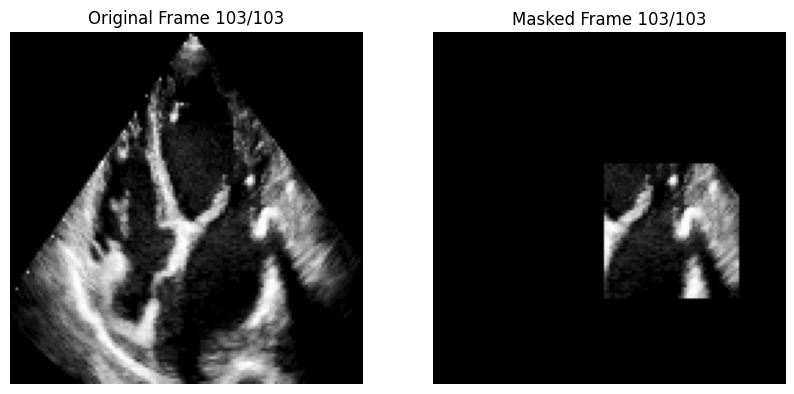

In [533]:
test_video_0 = test_data[0]['video']
vid = np.zeros((128,128,test_video_0.shape[2]))
for i in range(test_video_0.shape[2]):
    vid[:,:,i] = cv2.resize(test_video_0[:,:,i].astype(np.uint8), (128, 128))
   

vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)
#print(frames.shape)


model.eval()
frame_box_coords = model(frames)
boxes = reconstruct_box_centers_batch(frame_box_coords)

video_frames = frames.squeeze().permute(1, 2, 0)
video_boxes = boxes.permute(1, 2, 0)
#print(video_frames.shape)
#print(video_boxes.shape)

show_video(frames=video_frames.detach().numpy(), masks=video_boxes.detach().numpy(), speed=0.05)


## Homogenize Box size in datasets

In [435]:
def crop_frames_adjust_boxes_dataset(dataset):
    boxes = dataset.boxes_data
    new_boxes = []
    
    for i in range(len(boxes)):
        new_boxes.append(substitute_with_my_box(boxes[i]))
    
    new_boxes = np.array(new_boxes) 
    dataset.boxes_data = new_boxes
    
    frames = dataset.frames_data
    boxes = dataset.boxes_data
    cropped_frames = []
    
    for i in range(len(frames)):
        cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
        
    new_frames = np.array(cropped_frames)
    dataset.frames_data = new_frames
    
    labels = dataset.labels_data
    cropped_labels = []
    
    for i in range(len(labels)):
        cropped_labels.append(get_cropped_frame(labels[i], boxes[i]))
        
    new_labels = np.array(cropped_labels)
    dataset.labels_data = new_labels

        
        
crop_frames_adjust_boxes_dataset(amateur_train_dataset)
crop_frames_adjust_boxes_dataset(expert_train_dataset)
crop_frames_adjust_boxes_dataset(all_train_dataset)

In [ ]:
frame, box, label = amateur_train_dataset.__getitem__(5)

print(label.shape)
plt.imshow(label)
plt.show()

## Train UNET

In [453]:
unet_model = SimpleUNet()
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

train_loader_amateur = DataLoader(amateur_train_dataset, batch_size=16, shuffle=True)
num_epoch = 20

for epoch in range(num_epoch):
    unet_model.train()
    total_loss = 0

    for frame_batch, box_batch, label_batch in train_loader_amateur:
        
        frame_batch, label_batch = frame_batch.to(device), label_batch.to(device)
        frame_batch = frame_batch.unsqueeze(1)
        optimizer_unet.zero_grad()
    
        #print(frame_batch.shape)
        #print(label_batch.shape)
        #break
        
        preds = unet_model(frame_batch)
        preds = preds.squeeze()
        #print(preds.shape)
        #print(label_batch.shape)
        #break
    
        loss = F.binary_cross_entropy(preds, label_batch)
        #print(loss)
        #break

        loss.backward()
        optimizer_unet.step()
        
        total_loss += loss.item()    
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader_amateur)}")

Epoch 1/20, Loss: 0.5236170424355401
Epoch 2/20, Loss: 0.44436098138491315
Epoch 3/20, Loss: 0.38672101828787064
Epoch 4/20, Loss: 0.34379323323567706
Epoch 5/20, Loss: 0.31302648451593185
Epoch 6/20, Loss: 0.2913326687282986
Epoch 7/20, Loss: 0.27463218238618636
Epoch 8/20, Loss: 0.2609780232111613
Epoch 9/20, Loss: 0.24952007664574516
Epoch 10/20, Loss: 0.24037670095761618
Epoch 11/20, Loss: 0.2323011342022154
Epoch 12/20, Loss: 0.22549803720580208
Epoch 13/20, Loss: 0.2195739878548516
Epoch 14/20, Loss: 0.21318868299325308
Epoch 15/20, Loss: 0.20836624834272596
Epoch 16/20, Loss: 0.2029428846306271
Epoch 17/20, Loss: 0.19817034237914616
Epoch 18/20, Loss: 0.19379606511857775
Epoch 19/20, Loss: 0.19119651118914285
Epoch 20/20, Loss: 0.18789641393555534


## UNET testing

torch.Size([5, 1, 48, 48])


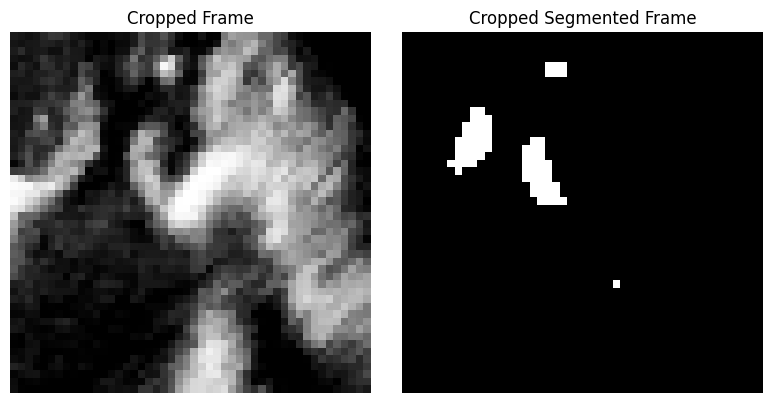

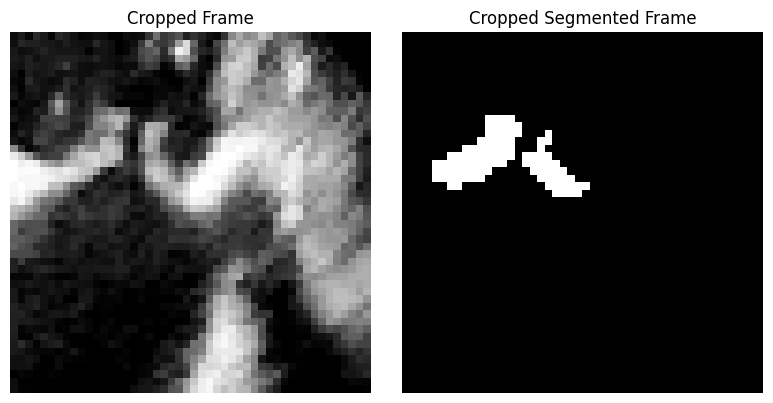

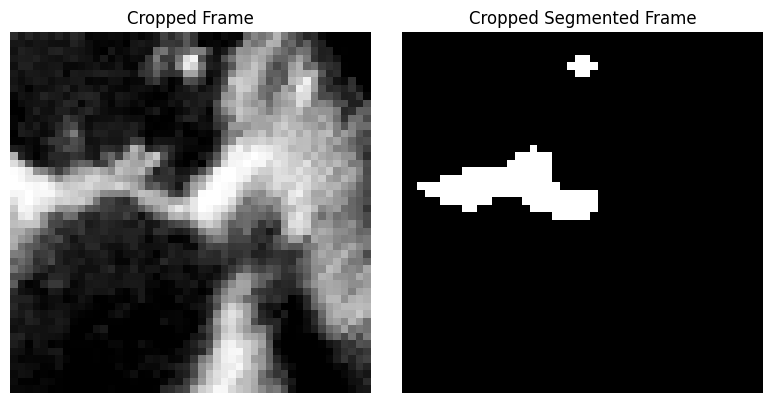

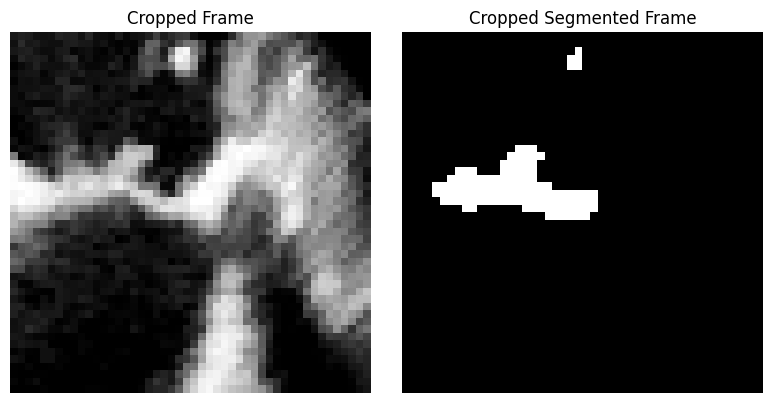

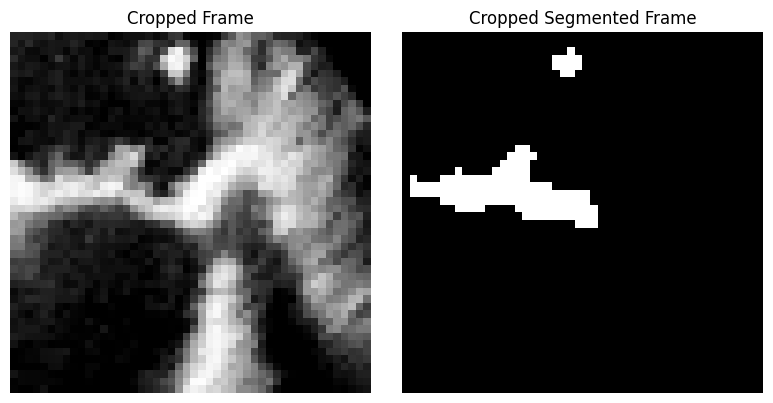

In [531]:
test_video_0 = test_data[0]['video']
vid = np.zeros((128,128,test_video_0.shape[2]))
for i in range(test_video_0.shape[2]):
    vid[:,:,i] = cv2.resize(test_video_0[:,:,i].astype(np.uint8), (128, 128))
    
vid = vid[:,:,0:5]
vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)
#print(frames.shape)

model.eval()
frame_box_coords = model(frames)
frames = frames.squeeze()
boxes = reconstruct_box_centers_batch(frame_box_coords)

cropped_frames = []
for i in range(5):
    cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
    
cropped_frames = torch.FloatTensor(np.array(cropped_frames))
cropped_frames = cropped_frames.unsqueeze(1)
print(cropped_frames.shape)


unet_model.eval()
segmented_cropped_frame = unet_model(cropped_frames)
#print("Segmented Cropped Frames shape:")
#print(segmented_cropped_frame.shape)

for i in range(5):
    abba = segmented_cropped_frame[i].squeeze().detach().numpy()
    abba = abba > 0.7

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(cropped_frames[i,:,:].squeeze(), cmap='gray')
    title0 = "Cropped Frame"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(abba, cmap='gray')
    title1 = "Cropped Segmented Frame"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()